---
title: "Lab 7: Heart Attack"
format: 
  html:
    embed-resources: true
execute:
  echo: true
code-fold: true
author: James Compagno
jupyter: python3
---

# The Data

In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise. The information collected includes:

- **age**: Age of the patient

- **sex**: Sex of the patient

- **cp**: Chest Pain type
  - Value 0: asymptomatic
  - Value 1: typical angina
  - Value 2: atypical angina
  - Value 3: non-anginal pain

- **trtbps**: resting blood pressure (in mm Hg)

- **chol**: cholesterol in mg/dl fetched via BMI sensor

- **restecg**: resting electrocardiographic results
  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- **thalach**: maximum heart rate achieved during exercise

- **output**: the doctor's diagnosis of whether the patient is at risk for a heart attack
  - 0 = not at risk of heart attack
  - 1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

In [2]:
# Read the data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha = ha.dropna()

ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


In [3]:
# Closer Look at Chest Pain
print("Chest Pain (cp) Distribution:")
print(ha['cp'].value_counts().sort_index())
print("\nProportions:")
print(ha['cp'].value_counts(normalize=True).sort_index())

# Cross-tabulation with output (heart attack risk)
print("\nChest Pain Type by Heart Attack Risk:")
print(pd.crosstab(ha['cp'], ha['output'], margins=True))

Chest Pain (cp) Distribution:
cp
0    128
1     44
2     81
3     20
Name: count, dtype: int64

Proportions:
cp
0    0.468864
1    0.161172
2    0.296703
3    0.073260
Name: proportion, dtype: float64

Chest Pain Type by Heart Attack Risk:
output    0    1  All
cp                   
0        94   34  128
1         8   36   44
2        18   63   81
3         7   13   20
All     127  146  273


With almost 50% of patients expirencing asymtomatic chest pain more must be looked ast besides that especially since doctors later went on to diagnose 34/128 "asymtomatic" patients as "At Risk." 

In [4]:
# Separate X and Y
y = ha['output']
X = ha.drop(columns=['output'])

# Numeric and Categorical 
categorical_features = ['sex', 'cp', 'restecg']
numerical_features = ['age', 'trtbps', 'chol', 'thalach']

# Train/test split on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)

# Model Library 
model_library = {}
records = []

In [5]:
# Column Transformer 
ct = ColumnTransformer(
    [
        ("standardize", 
         StandardScaler(), 
         numerical_features),
        ("encode",
         OneHotEncoder(drop='first', sparse_output=False),
         categorical_features)
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Part One: Fitting Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on `ROC AUC` for predicting the `target` variable.

- Report the (cross-validated!) `ROC AUC` metric.

- Fit the final model.

- Output a **confusion matrix**; that is, the counts of how many observations fell into each predicted class for each true class.

- (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You *should* include any hyperparameter tuning steps in your writeup as well.

## Q1: KNN

In [6]:
def knn_gridsearch(model_name, features=None, k_range=None):
    """
    Uses GridSearchCV to find the best K value for KNN
    model_name - will be stored in model_library
    k_range - list of k values to test 
    features - list or None 
    """
    
    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with KNN Classifier
    pipe = Pipeline([
        ("preprocess", ct),
        ("knn", KNeighborsClassifier())
    ])
    
    # Parameter grid
    param_grid = {
        'knn__n_neighbors': k_range 
    }
    
    # GridSearchCV ROC AUC 
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    
    # Fit GridSearch
    grid_search.fit(X_train_subset, y_train)
    
    # Store best model
    best_model = grid_search.best_estimator_
    model_library[model_name] = best_model
    
    # Best parameters
    best_k = grid_search.best_params_['knn__n_neighbors']
    best_cv_score = grid_search.best_score_
    
    # Test Set Performance
    y_pred_test = best_model.predict(X_test_subset)
    y_pred_proba = best_model.predict_proba(X_test_subset)[:, 1]
    
    # Metrics
    conf_matrix = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    tn, fp, fn, tp = conf_matrix.ravel()
    
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Store results
    records.append({
        "Model": model_name,
        "Classification Type": "KNN",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "KNNeighbors", 
        "Hyperparameter 1 Value": best_k,
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        "Range Tested": k_range,
        "ROC AUC Mean (CV)": best_cv_score,
        "Test ROC AUC": test_roc_auc,
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
    })
    
    # Print results
    print(f"\n=== {model_name} ===")
    print(f"Best K: {best_k}")
    print(f"Best CV ROC AUC: {best_cv_score:.4f}")
    print(f"\nTest Set Performance:")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['No Risk', 'At Risk']))
    
    return grid_search

In [7]:
knn_gridsearch("KNN_Prime", k_range=[3, 5, 7, 9, 11, 13, 15])


=== KNN_Prime ===
Best K: 13
Best CV ROC AUC: 0.8107

Test Set Performance:
ROC AUC: 0.7334
Accuracy: 0.7091
Precision: 0.7097
Recall/Sensitivity: 0.7586
Specificity: 0.6538

Confusion Matrix:
[[17  9]
 [ 7 22]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.71      0.65      0.68        26
     At Risk       0.71      0.76      0.73        29

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.71      0.71      0.71        55



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15]},
             return_train_score=True, scoring='roc_auc')

In [8]:
knn_gridsearch("KNN_Wide", k_range=[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51])


=== KNN_Wide ===
Best K: 11
Best CV ROC AUC: 0.8002

Test Set Performance:
ROC AUC: 0.7407
Accuracy: 0.6909
Precision: 0.7000
Recall/Sensitivity: 0.7241
Specificity: 0.6538

Confusion Matrix:
[[17  9]
 [ 8 21]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.68      0.65      0.67        26
     At Risk       0.70      0.72      0.71        29

    accuracy                           0.69        55
   macro avg       0.69      0.69      0.69        55
weighted avg       0.69      0.69      0.69        55



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 19, 25, 31,
                                              41, 51]},
             return_train_score=True, scoring='roc_auc')

In [9]:
knn_gridsearch("KNN_Evens", k_range=[2, 4, 6, 8, 10, 12, 14, 16])


=== KNN_Evens ===
Best K: 12
Best CV ROC AUC: 0.8056

Test Set Performance:
ROC AUC: 0.7407
Accuracy: 0.6545
Precision: 0.6923
Recall/Sensitivity: 0.6207
Specificity: 0.6923

Confusion Matrix:
[[18  8]
 [11 18]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.62      0.69      0.65        26
     At Risk       0.69      0.62      0.65        29

    accuracy                           0.65        55
   macro avg       0.66      0.66      0.65        55
weighted avg       0.66      0.65      0.65        55



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16]},
             return_train_score=True, scoring='roc_auc')

In [10]:
dfKNN = pd.DataFrame(records)
dfKNN[dfKNN['Classification Type'] == 'KNN'].sort_values('ROC AUC Mean (CV)', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC Mean (CV),Test ROC AUC,Test Accuracy,Confusion Matrix,Precision,Recall,Specificity
0,KNN_Prime,KNN,All,KNNeighbors,13,NA,NA,"[3, 5, 7, 9, 11, 13, 15]",0.810678,0.733422,0.709091,"[[17, 9], [7, 22]]",0.709677,0.758621,0.653846
2,KNN_Evens,KNN,All,KNNeighbors,12,NA,NA,"[2, 4, 6, 8, 10, 12, 14, 16]",0.805628,0.740716,0.654545,"[[18, 8], [11, 18]]",0.692308,0.620690,0.692308
1,KNN_Wide,KNN,All,KNNeighbors,11,NA,NA,"[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51]",0.800164,0.740716,0.690909,"[[17, 9], [8, 21]]",0.700000,0.724138,0.653846


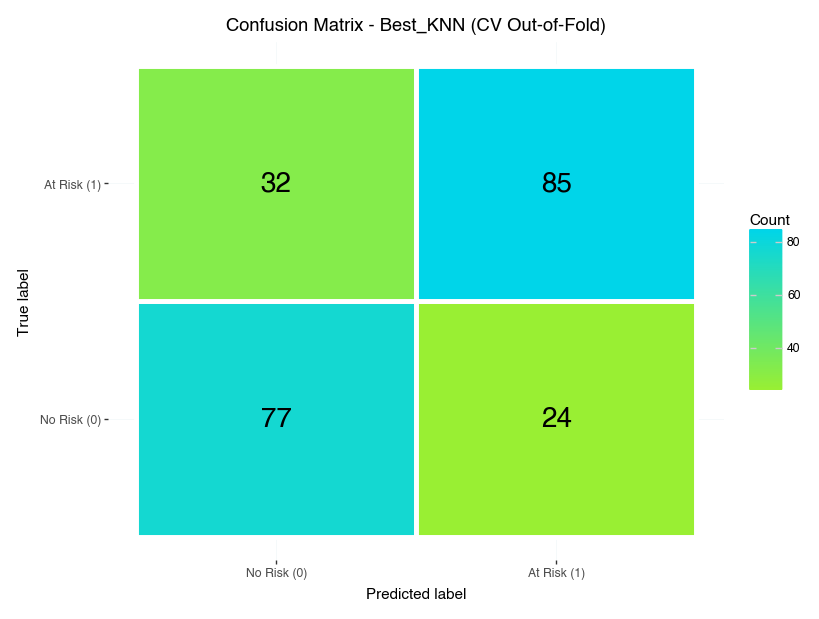

In [11]:
# Select the best KNN model
best_knn_model = model_library['KNN_Prime']

# Cross-validated predictions
knn_oof = cross_val_predict(best_knn_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_pred_oof = (knn_oof >= 0.5).astype(int)

# Calculate metrics
cm_oof = confusion_matrix(y_train, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm_oof.ravel()

# Create dataframe 
cm_df = pd.DataFrame({
    'True_Label': [0, 0, 1, 1],
    'Predicted_Label': [0, 1, 0, 1],
    'Count': [tn, fp, fn, tp]
})

# Plot
(p9.ggplot(cm_df, p9.aes(x='factor(Predicted_Label)', y='factor(True_Label)', fill='Count'))
    + p9.geom_tile(color='white', size=2)
    + p9.geom_text(p9.aes(label='Count'), size=20, color='black')
    + p9.scale_fill_gradient(low='#99ef33', high='#00d5e9')
    + p9.scale_x_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.scale_y_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.labs(
        title='Confusion Matrix - Best_KNN',
        x='Predicted label',
        y='True label'
    )
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        panel_background=p9.element_rect(fill="white"), 
        panel_grid_major=p9.element_line(color="#f2f7f8", size=0.5)
    )
)

The KNN model achieved a ROC AUC of 0.81, demonstrating good ability to distinguish between at-risk and no-risk patients.

It captured about 76% of actual at-risk patients (recall/sensitivity) and was correct 71% of the time when predicting someone as at-risk (precision).

It correctly identified 66% of no-risk patients (specificity).

The main concern is the model missed 32 at-risk patients (false negatives) and incorrectly flagged 24 no-risk patients as at-risk (false positives).

Overall: This is a solid performing model with K=13 neighbors, though the 32 false negatives are concerning from a medical perspective where missing at-risk patients could have serious consequences.

## Q2: Logistic Regression

In [12]:
def logistic_gridsearch(model_name, features=None, C_range=None):
    """
    Uses GridSearchCV to find the best hyperparameters for Logistic Regression with ElasticNet
    model_name - will be stored in model_library
    C_range - list of regularization strength values to test 
    features - list or None 
    """

    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with Logistic Regression (ElasticNet penalty)
    pipe = Pipeline([
        ("preprocess", ct),
        ("logistic", LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, random_state=67, l1_ratio=0.5))
    ])
    
    # Parameter grid
    param_grid = {
        'logistic__C': C_range
    }
    
    # GridSearchCV ROC AUC 
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    
    # Fit GridSearch
    grid_search.fit(X_train_subset, y_train)
    
    # Store best model
    best_model = grid_search.best_estimator_
    model_library[model_name] = best_model
    
    # Best parameters
    best_C = grid_search.best_params_['logistic__C']
    best_cv_score = grid_search.best_score_
    
    # Test Set Performance
    y_pred_test = best_model.predict(X_test_subset)
    y_pred_proba = best_model.predict_proba(X_test_subset)[:, 1]
    
    # Metrics
    conf_matrix = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    tn, fp, fn, tp = conf_matrix.ravel()
    
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Store results
    records.append({
        "Model": model_name,
        "Classification Type": "Logistic",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "C", 
        "Hyperparameter 1 Value": best_C,
        "Hyperparameter 2 Name": "Penalty",
        "Hyperparameter 2 Value": "ElasticNet",
        "Range Tested": C_range,
        "ROC AUC Mean (CV)": best_cv_score,
        "Test ROC AUC": test_roc_auc,
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity
    })
    
    # Print results
    print(f"\n=== {model_name} ===")
    print(f"Best C: {best_C}")
    print(f"Penalty: elasticnet (l1_ratio=0.5)")
    print(f"Best CV ROC AUC: {best_cv_score:.4f}")
    print(f"\nTest Set Performance:")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['No Risk', 'At Risk']))
    
    # Print coefficients for interpretation
    print(f"\nModel Coefficients (for interpretation):")
    feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
    coefficients = best_model.named_steps['logistic'].coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values('Coefficient', key=abs, ascending=False)
    print(coef_df.to_string(index=False))
    
    return grid_search

In [13]:
logistic_gridsearch("Logistic_Basic",  C_range=[0.001, 0.01, 0.1, 1, 10, 100])


=== Logistic_Basic ===
Best C: 1
Penalty: elasticnet (l1_ratio=0.5)
Best CV ROC AUC: 0.8624

Test Set Performance:
ROC AUC: 0.7997
Accuracy: 0.7091
Precision: 0.7241
Recall/Sensitivity: 0.7241
Specificity: 0.6923

Confusion Matrix:
[[18  8]
 [ 8 21]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.69      0.69      0.69        26
     At Risk       0.72      0.72      0.72        29

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.71      0.71      0.71        55


Model Coefficients (for interpretation):
  Feature  Coefficient
    sex_1    -2.100729
     cp_2     1.635534
     cp_1     1.582857
  thalach     0.878401
     cp_3     0.574715
   trtbps    -0.487121
restecg_1     0.358070
     chol    -0.312026
      age    -0.091942
restecg_2     0.000000


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('logistic',
                                        LogisticRegression(l1_ratio=0.5,
                                                           max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=67,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='roc_auc')

In [14]:
logistic_gridsearch("Logistic_Wide", C_range=[0.001, 0.01, 0.1, 1, 10, 100, 1000])


=== Logistic_Wide ===
Best C: 1
Penalty: elasticnet (l1_ratio=0.5)
Best CV ROC AUC: 0.8624

Test Set Performance:
ROC AUC: 0.7997
Accuracy: 0.7091
Precision: 0.7241
Recall/Sensitivity: 0.7241
Specificity: 0.6923

Confusion Matrix:
[[18  8]
 [ 8 21]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.69      0.69      0.69        26
     At Risk       0.72      0.72      0.72        29

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.71      0.71      0.71        55


Model Coefficients (for interpretation):
  Feature  Coefficient
    sex_1    -2.100729
     cp_2     1.635534
     cp_1     1.582857
  thalach     0.878401
     cp_3     0.574715
   trtbps    -0.487121
restecg_1     0.358070
     chol    -0.312026
      age    -0.091942
restecg_2     0.000000


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('logistic',
                                        LogisticRegression(l1_ratio=0.5,
                                                           max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=67,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [15]:
logistic_gridsearch("Logistic_Strong", C_range=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])


=== Logistic_Strong ===
Best C: 0.1
Penalty: elasticnet (l1_ratio=0.5)
Best CV ROC AUC: 0.8132

Test Set Performance:
ROC AUC: 0.7798
Accuracy: 0.7273
Precision: 0.7188
Recall/Sensitivity: 0.7931
Specificity: 0.6538

Confusion Matrix:
[[17  9]
 [ 6 23]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.74      0.65      0.69        26
     At Risk       0.72      0.79      0.75        29

    accuracy                           0.73        55
   macro avg       0.73      0.72      0.72        55
weighted avg       0.73      0.73      0.73        55


Model Coefficients (for interpretation):
  Feature  Coefficient
    sex_1    -0.771332
  thalach     0.662150
     cp_2     0.573778
   trtbps    -0.264254
     cp_1     0.230906
     chol    -0.099569
restecg_1     0.098177
      age    -0.027911
     cp_3     0.000000
restecg_2     0.000000


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('logistic',
                                        LogisticRegression(l1_ratio=0.5,
                                                           max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=67,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.0001, 0.0005, 0.001, 0.005, 0.01,
                                         0.05, 0.1]},
             return_train_score=True, scoring='roc_auc')

In [16]:
dflog = pd.DataFrame(records)
dflog[dflog['Classification Type'] == 'Logistic'].sort_values('ROC AUC Mean (CV)', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC Mean (CV),Test ROC AUC,Test Accuracy,Confusion Matrix,Precision,Recall,Specificity
3,Logistic_Basic,Logistic,All,C,1.0,Penalty,ElasticNet,"[0.001, 0.01, 0.1, 1, 10, 100]",0.862435,0.799735,0.709091,"[[18, 8], [8, 21]]",0.724138,0.724138,0.692308
4,Logistic_Wide,Logistic,All,C,1.0,Penalty,ElasticNet,"[0.001, 0.01, 0.1, 1, 10, 100, 1000]",0.862435,0.799735,0.709091,"[[18, 8], [8, 21]]",0.724138,0.724138,0.692308
5,Logistic_Strong,Logistic,All,C,0.1,Penalty,ElasticNet,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]",0.813178,0.779841,0.727273,"[[17, 9], [6, 23]]",0.718750,0.793103,0.653846


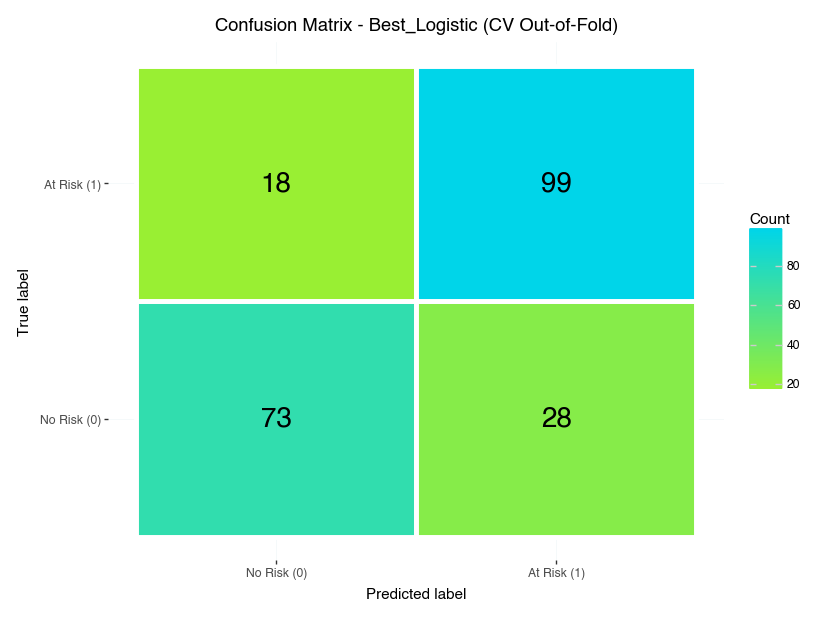

In [17]:
# Select the best Logistic model
best_logistic_model = model_library['Logistic_Wide']

# Cross-validated predictions
logistic_oof = cross_val_predict(best_logistic_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_pred_oof = (logistic_oof >= 0.5).astype(int)

# Calculate metrics
cm_oof = confusion_matrix(y_train, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm_oof.ravel()

# Create dataframe 
cm_df = pd.DataFrame({
    'True_Label': [0, 0, 1, 1],
    'Predicted_Label': [0, 1, 0, 1],
    'Count': [tn, fp, fn, tp]
})

# Plot
(p9.ggplot(cm_df, p9.aes(x='factor(Predicted_Label)', y='factor(True_Label)', fill='Count'))
    + p9.geom_tile(color='white', size=2)
    + p9.geom_text(p9.aes(label='Count'), size=20, color='black')
    + p9.scale_fill_gradient(low='#99ef33', high='#00d5e9')
    + p9.scale_x_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.scale_y_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.labs(
        title='Confusion Matrix - Best_Logistic',
        x='Predicted label',
        y='True label'
    )
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        panel_background=p9.element_rect(fill="white"), 
        panel_grid_major=p9.element_line(color="#f2f7f8", size=0.5)
    )
)

The Logistic Regression model achieved a ROC AUC of 0.86, better than KNN. 

It captured about 72% of actual at-risk patients (recall/sensitivity) and was correct 72% of the time when predicting someone as at-risk (precision).

It correctly identified 69% of no-risk patients (specificity).

The main concern is the model missed 18 at-risk patients (false negatives) and incorrectly flagged 28 no-risk patients as at-risk (false positives).

Overall: While it has fewer false negatives (18 vs 32 for KNN), which is crucial in medical diagnosis, it does have slightly more false positives. 

## Q3: Decision Tree

In [18]:
def tree_gridsearch(model_name, features=None, max_depth_range=None):
    """
    Uses GridSearchCV to find the best max_depth for Decision Tree
    model_name - will be stored in model_library
    max_depth_range - list of max_depth values to test
    features - list or None 
    """

    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with Decision Tree
    pipe = Pipeline([
        ("preprocess", ct),
        ("tree", DecisionTreeClassifier(random_state=67))
    ])
    
    # Parameter grid
    param_grid = {
        'tree__max_depth': max_depth_range
    }
    
    # GridSearchCV ROC AUC 
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    
    # Fit GridSearch
    grid_search.fit(X_train_subset, y_train)
    
    # Store best model
    best_model = grid_search.best_estimator_
    model_library[model_name] = best_model
    
    # Best parameters
    best_max_depth = grid_search.best_params_['tree__max_depth']
    best_cv_score = grid_search.best_score_
    
    # Test Set Performance
    y_pred_test = best_model.predict(X_test_subset)
    y_pred_proba = best_model.predict_proba(X_test_subset)[:, 1]
    
    # Metrics
    conf_matrix = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    tn, fp, fn, tp = conf_matrix.ravel()
    
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Store results
    records.append({
        "Model": model_name,
        "Classification Type": "Decision Tree",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "Max Depth", 
        "Hyperparameter 1 Value": best_max_depth,
        "Hyperparameter 2 Name": "NA",
        "Hyperparameter 2 Value": "NA",
        "Range Tested": max_depth_range,
        "ROC AUC Mean (CV)": best_cv_score,
        "Test ROC AUC": test_roc_auc,
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity
    })
    
    # Print results
    print(f"\n=== {model_name} ===")
    print(f"Best Max Depth: {best_max_depth}")
    print(f"Best CV ROC AUC: {best_cv_score:.4f}")
    print(f"\nTest Set Performance:")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['No Risk', 'At Risk']))
    
    # Print feature importances for interpretation
    print(f"\nFeature Importances (for interpretation):")
    feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
    importances = best_model.named_steps['tree'].feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    print(importance_df[importance_df['Importance'] > 0].to_string(index=False))
    
    return grid_search

In [19]:
tree_gridsearch("Tree_Prime", max_depth_range=[3, 5, 7, 9, 11, 13, 15])


=== Tree_Prime ===
Best Max Depth: 3
Best CV ROC AUC: 0.7186

Test Set Performance:
ROC AUC: 0.6214
Accuracy: 0.6545
Precision: 0.6786
Recall/Sensitivity: 0.6552
Specificity: 0.6538

Confusion Matrix:
[[17  9]
 [10 19]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.63      0.65      0.64        26
     At Risk       0.68      0.66      0.67        29

    accuracy                           0.65        55
   macro avg       0.65      0.65      0.65        55
weighted avg       0.66      0.65      0.65        55


Feature Importances (for interpretation):
Feature  Importance
thalach    0.397436
  sex_1    0.237027
 trtbps    0.177519
    age    0.119300
   cp_1    0.068719


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=67))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [3, 5, 7, 9, 11, 13, 15]},
             return_train_score=True, scoring='roc_auc')

In [20]:
tree_gridsearch("Tree_Wide", max_depth_range=[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51])


=== Tree_Wide ===
Best Max Depth: 3
Best CV ROC AUC: 0.7186

Test Set Performance:
ROC AUC: 0.6214
Accuracy: 0.6545
Precision: 0.6786
Recall/Sensitivity: 0.6552
Specificity: 0.6538

Confusion Matrix:
[[17  9]
 [10 19]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.63      0.65      0.64        26
     At Risk       0.68      0.66      0.67        29

    accuracy                           0.65        55
   macro avg       0.65      0.65      0.65        55
weighted avg       0.66      0.65      0.65        55


Feature Importances (for interpretation):
Feature  Importance
thalach    0.397436
  sex_1    0.237027
 trtbps    0.177519
    age    0.119300
   cp_1    0.068719


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=67))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 3, 5, 7, 9, 11, 15, 19, 25, 31,
                                             41, 51]},
             return_train_score=True, scoring='roc_auc')

In [21]:
tree_gridsearch("Tree_Evens", max_depth_range=[2, 4, 6, 8, 10, 12, 14, 16])


=== Tree_Evens ===
Best Max Depth: 2
Best CV ROC AUC: 0.7122

Test Set Performance:
ROC AUC: 0.7785
Accuracy: 0.7091
Precision: 0.6757
Recall/Sensitivity: 0.8621
Specificity: 0.5385

Confusion Matrix:
[[14 12]
 [ 4 25]]

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.78      0.54      0.64        26
     At Risk       0.68      0.86      0.76        29

    accuracy                           0.71        55
   macro avg       0.73      0.70      0.70        55
weighted avg       0.72      0.71      0.70        55


Feature Importances (for interpretation):
Feature  Importance
thalach    0.590488
  sex_1    0.232263
    age    0.177249


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('encode',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'cp',
                                                                          'restecg'])],
                                                          verbose_feature_names_out=False)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=67))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [2, 4, 6, 8, 10, 12, 14, 16]},
             return_train_score=True, scoring='roc_auc')

In [22]:
dfTree = pd.DataFrame(records)
dfTree[dfTree['Classification Type'] == 'Decision Tree'].sort_values('ROC AUC Mean (CV)', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC Mean (CV),Test ROC AUC,Test Accuracy,Confusion Matrix,Precision,Recall,Specificity
6,Tree_Prime,Decision Tree,All,Max Depth,3.0,NA,NA,"[3, 5, 7, 9, 11, 13, 15]",0.718595,0.621353,0.654545,"[[17, 9], [10, 19]]",0.678571,0.655172,0.653846
7,Tree_Wide,Decision Tree,All,Max Depth,3.0,NA,NA,"[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51]",0.718595,0.621353,0.654545,"[[17, 9], [10, 19]]",0.678571,0.655172,0.653846
8,Tree_Evens,Decision Tree,All,Max Depth,2.0,NA,NA,"[2, 4, 6, 8, 10, 12, 14, 16]",0.712208,0.778515,0.709091,"[[14, 12], [4, 25]]",0.675676,0.862069,0.538462


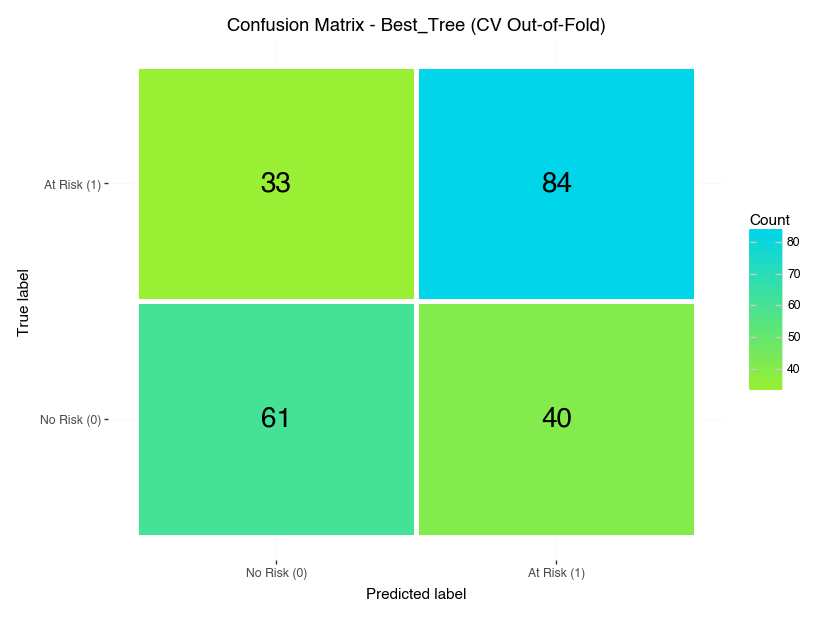

In [ ]:
# Select the best Tree model
best_tree_model = model_library['Tree_Wide']

# Cross-validated predictions
tree_oof = cross_val_predict(best_tree_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_pred_oof = (tree_oof >= 0.5).astype(int)

# Calculate metrics
cm_oof = confusion_matrix(y_train, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm_oof.ravel()

# Create dataframe 
cm_df = pd.DataFrame({
    'True_Label': [0, 0, 1, 1],
    'Predicted_Label': [0, 1, 0, 1],
    'Count': [tn, fp, fn, tp]
})

# Plot
(p9.ggplot(cm_df, p9.aes(x='factor(Predicted_Label)', y='factor(True_Label)', fill='Count'))
    + p9.geom_tile(color='white', size=2)
    + p9.geom_text(p9.aes(label='Count'), size=20, color='black')
    + p9.scale_fill_gradient(low='#99ef33', high='#00d5e9')
    + p9.scale_x_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.scale_y_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.labs(
        title='Confusion Matrix - Best_Tree',
        x='Predicted label',
        y='True label'
    )
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        panel_background=p9.element_rect(fill="white"), 
        panel_grid_major=p9.element_line(color="#f2f7f8", size=0.5)
    )
)

The Decision Tree model achieved a ROC AUC of 0.72, lower than both KNN (0.81) and Logistic (0.86).

It captured about 66% of actual at-risk patients (recall/sensitivity) and was correct 68% of the time when predicting someone as at-risk (precision).

It correctly identified 65% of no-risk patients (specificity).

The main concern is the model missed 33 at-risk patients (false negatives) and incorrectly flagged 40 no-risk patients as at-risk (false positives).

Overall: This is the weakest performer among the three models. It has the most false negatives (33), most false positives (40), and lowest ROC AUC.

## Q4: Interpretation

Which predictors were most important to predicting heart attack risk?

In [29]:
pd.DataFrame(records).sort_values('ROC AUC Mean (CV)', ascending=False).head(3)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC Mean (CV),Test ROC AUC,Test Accuracy,Confusion Matrix,Precision,Recall,Specificity
3,Logistic_Basic,Logistic,All,C,1.0,Penalty,ElasticNet,"[0.001, 0.01, 0.1, 1, 10, 100]",0.862435,0.799735,0.709091,"[[18, 8], [8, 21]]",0.724138,0.724138,0.692308
4,Logistic_Wide,Logistic,All,C,1.0,Penalty,ElasticNet,"[0.001, 0.01, 0.1, 1, 10, 100, 1000]",0.862435,0.799735,0.709091,"[[18, 8], [8, 21]]",0.724138,0.724138,0.692308
5,Logistic_Strong,Logistic,All,C,0.1,Penalty,ElasticNet,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]",0.813178,0.779841,0.727273,"[[17, 9], [6, 23]]",0.718750,0.793103,0.653846


In [ ]:
# best_tree = model_library['Tree_Wide']  
# feature_names = best_tree.named_steps['preprocess'].get_feature_names_out()

# # Feature Importances
# tree_imp = pd.DataFrame({
#     "Feature": feature_names,
#     "Importance": best_tree.named_steps['tree'].feature_importances_
# }).sort_values("Importance", ascending=False)
# display(tree_imp)

,Feature,Importance
3,thalach,0.397436
4,sex_1,0.237027
1,trtbps,0.177519
0,age,0.119300
5,cp_1,0.068719
2,chol,0.000000
6,cp_2,0.000000
7,cp_3,0.000000
8,restecg_1,0.000000
9,restecg_2,0.000000


In [34]:
best_logistic = model_library['Logistic_Wide']

feature_names = best_logistic.named_steps['preprocess'].get_feature_names_out()

logit_coefs = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_logistic.named_steps['logistic'].coef_[0]
}).sort_values("Coefficient", key=abs, ascending=False)


display(logit_coefs)

,Feature,Coefficient
4,sex_1,-2.100729
6,cp_2,1.635534
5,cp_1,1.582857
3,thalach,0.878401
7,cp_3,0.574715
1,trtbps,-0.487121
8,restecg_1,0.358070
2,chol,-0.312026
0,age,-0.091942
9,restecg_2,0.000000


Based on the Logistic Regression model (our best performer), the most important predictors were:

1. sex_1 (Male): Coefficient = -2.10 - Being male decreases the predicted risk of heart attack in this model. This is the strongest predictor overall. This however goes against converntional medical wisdom. 

2. cp_2 (Atypical angina): Coefficient = 1.64 - Having atypical angina increases heart attack risk.

3. cp_1 (Typical angina): Coefficient = 1.58 - Having typical angina chest pain also increases heart attack risk.

4. thalach (Max heart rate): Coefficient = 0.88 - Higher maximum heart rate during exercise increases heart attack risk.

5. cp_3 (Non-anginal pain): Coefficient = 0.57 - Non-anginal chest pain moderately increases risk.

The logistic regression coefficients reveal that sex and chest pain type are the strongest predictors of heart attack risk. Against converntional wisdom, being male decreases predicted risk in this model. Having any of the types of chest pain (especially atypical and typical angina) are strong positive indicators.

## 5: ROC Curve

Plot the ROC Curve for your three models above.

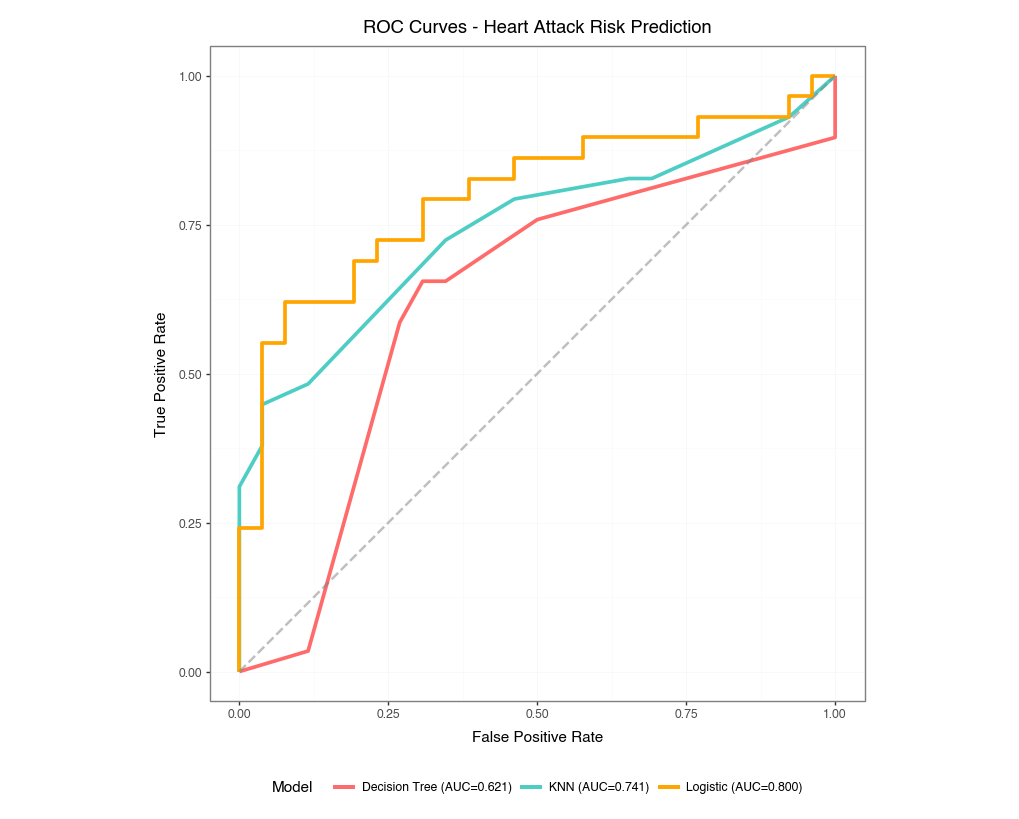

In [35]:
# Pick Models
best_knn = model_library['KNN_Wide']
best_logistic = model_library['Logistic_Wide'] 
best_tree = model_library['Tree_Wide']

# Get predictions 
knn_proba = best_knn.predict_proba(X_test)[:, 1]
logistic_proba = best_logistic.predict_proba(X_test)[:, 1]
tree_proba = best_tree.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_proba)
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_proba)

# Calculate AUC scores
auc_knn = auc(fpr_knn, tpr_knn)
auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_tree = auc(fpr_tree, tpr_tree)

# Create dataframes 
roc_knn = pd.DataFrame({'FPR': fpr_knn, 'TPR': tpr_knn, 'Model': f'KNN (AUC={auc_knn:.3f})'})
roc_logistic = pd.DataFrame({'FPR': fpr_logistic, 'TPR': tpr_logistic, 'Model': f'Logistic (AUC={auc_logistic:.3f})'})
roc_tree = pd.DataFrame({'FPR': fpr_tree, 'TPR': tpr_tree, 'Model': f'Decision Tree (AUC={auc_tree:.3f})'})

# All ROC curves
roc_df = pd.concat([roc_knn, roc_logistic, roc_tree])

# Diagonal line
diagonal_df = pd.DataFrame({'FPR': [0, 1], 'TPR': [0, 1]})


# Plot
(p9.ggplot()
    + p9.geom_line(roc_df, p9.aes(x='FPR', y='TPR', color='Model'), size=1.5)
    + p9.geom_line(diagonal_df, p9.aes(x='FPR', y='TPR'), 
                   color='gray', linetype='dashed', size=1, alpha=0.5)
    + p9.scale_color_manual(values=['#FF6B6B', '#4ECDC4', '#FFA500'])
    + p9.labs(
        title='ROC Curves - Heart Attack Risk Prediction',
        x='False Positive Rate',
        y='True Positive Rate',
        color='Model'
    )
    + p9.theme_bw()
    + p9.theme(
        figure_size=(10, 8),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#f2f7f8', size=0.5),
        legend_position='bottom'
    )
    + p9.coord_equal()
)

The curve confirms Logistic Regression as the most reliable choice for predicting heart attack risk, despite how jaggid it is.

# Part Two: Metrics

Consider the following metrics:

- **True Positive Rate** or **Recall** or **Sensitivity** = Of the observations that are truly Class A, how many were predicted to be Class A?

- **Precision** or **Positive Predictive Value** = Of all the observations classified as Class A, how many of them were truly from Class A?

- **True Negative Rate** or **Specificity** or **Negative Predictive Value** = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [27]:
# Filter to get your three best models
best_models = pd.DataFrame(records)[
    pd.DataFrame(records)['Model'].isin(['KNN_Wide', 'Logistic_Wide', 'Tree_Wide'])
]

# Display the metrics
metrics_display = best_models[[
    'Model', 
    'Classification Type',
    'ROC AUC Mean (CV)', 
    'Precision', 
    'Recall', 
    'Specificity'
]].set_index('Model')

display(metrics_display)

,Classification Type,ROC AUC Mean (CV),Precision,Recall,Specificity
Model,,,,,
KNN_Wide,KNN,0.800164,0.700000,0.724138,0.653846
Logistic_Wide,Logistic,0.862435,0.724138,0.724138,0.692308
Tree_Wide,Decision Tree,0.718595,0.678571,0.655172,0.653846


The table confirms Logistic Regression as the most reliable choice for predicting heart attack risk in all categories other than Recall where it is tied with KNN. 

# Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

- Which metric(s) you would use for model selection and why.

- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

## Q1

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

Use Recall as the key metric since it measures how many actual at-risk patients we correctly identify. I recommend the Logistic Regression model because it has the lowest false negatives (18).

## Q2

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

## Q3

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

## Q4

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

# Part Four: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

Use each of your final models in Part One Q1-3, predict the `target` variable in the validation dataset.

For each, output a confusion matrix, and report the `ROC AUC`, the `precision`, and the `recall`.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [28]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

# Part Five: Cohen's Kappa

Another common metric used in classification is Cohen's Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen's Kappa instead? Does this make sense?

In [36]:
from sklearn.metrics import cohen_kappa_score